<h1 style="text-align:center;">Training the Model</h1>

<br>

# Import the Packages

---

In [1]:
# Import the libraries
import numpy as np
import pandas as pd
from glob import glob
import matplotlib as mpl
import mplfinance as mpf
from typing import Iterable
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import clear_output
from IPython.core.display import display, HTML
import gym, gym.wrappers, time, requests, json, enum, warnings, pathlib
%matplotlib inline

In [2]:
# Import the libraries for DL and RL
import torch
from torch import nn
import torch.utils.data
import torch.optim as optim
from torch.functional import F
from torchsummary import summary
import ptan
import ptan.ignite as ptan_ignite
from ignite.engine import Engine
from ignite.metrics import RunningAverage
from ignite.contrib.handlers import tensorboard_logger as tb_logger

In [3]:
# Import the local libraries
from models import cnn_lstm
from environment import forex_trading_environment
from reinforcement_learning import rainbow
from data_helper import *

<br>

# Credentials

---

In [4]:
# Load the credential file
login_info = pd.read_excel("./credentials/forex login information.xlsx")
login_info

,Username,Password
0,soheil.mpg2,S6989490m


In [5]:
# Get the username and password
username_forex = login_info["Username"][0]
password_forex = login_info["Password"][0]

<br>

# Load the Dataset

---

In [6]:
# Load the dataset
dataset = pd.read_csv("./datasets/train/dataset.csv").reset_index()[["ticker", "time", "sell", "buy"]]
dataset = dataset.sort_values(by = ["ticker", "time"])
dataset.columns = ["Ticker", "Timestep", "Sell", "Buy"]
print("Dataset Shape: ", dataset.shape)
dataset.head()

Dataset Shape:  (5037257, 4)


,Ticker,Timestep,Sell,Buy
0,AUD/USD,1594623326,0.69776,0.69791
8,AUD/USD,1594623327,0.69777,0.69792
16,AUD/USD,1594623328,0.69781,0.69795
24,AUD/USD,1594623328,0.69781,0.69795
32,AUD/USD,1594623329,0.69781,0.69795


In [7]:
# Add more features to the dataset
df = add_features(dataset)
print("Dataset Shape: ", df.shape)
df.head()

Dataset Shape:  (5036757, 32)


,Timestep,Sell,Buy,Spread,Change - Sell,Simple Moving Average (SMA) - Sell,Exponential Moving Average (EMA) - Sell,Bollinger Bands (Upper) - Sell,Bollinger Bands (Lower) - Sell,Standard Deviation (STD) - Sell,...,Bollinger Bands (Lower) - Buy,Standard Deviation (STD) - Buy,Sharpe Ratio - Buy,Relative Strength Index (RSI) via EWMA - Buy,Relative Strength Index (RSI) via SMA - Buy,Fibonacci Retracement (Price Min) - Buy,Fibonacci Retracement (Level 1) - Buy,Fibonacci Retracement (Level 2) - Buy,Fibonacci Retracement (Level 3) - Buy,Fibonacci Retracement (Price Max) - Buy
0,1594623636,0.69802,0.69818,0.00016,0.000000,0.697776,0.697791,0.697966,0.697586,0.000095,...,0.697738,0.000094,0.041587,58.401030,55.378486,0.69778,0.698093,0.698033,0.697937,0.69819
1,1594623636,0.69803,0.69817,0.00014,0.000014,0.697777,0.697792,0.697968,0.697586,0.000096,...,0.697737,0.000095,0.038502,57.977625,54.980080,0.69778,0.698093,0.698033,0.697937,0.69819
2,1594623637,0.69802,0.69817,0.00015,-0.000014,0.697777,0.697792,0.697970,0.697585,0.000096,...,0.697737,0.000096,0.034059,57.977625,54.435484,0.69778,0.698093,0.698033,0.697937,0.69819
3,1594623638,0.69802,0.69817,0.00015,0.000000,0.697778,0.697793,0.697971,0.697584,0.000097,...,0.697736,0.000096,0.034059,57.977625,54.435484,0.69778,0.698093,0.698033,0.697937,0.69819
4,1594623638,0.69803,0.69817,0.00014,0.000014,0.697778,0.697794,0.697973,0.697583,0.000097,...,0.697735,0.000097,0.034059,57.977625,54.435484,0.69778,0.698093,0.698033,0.697937,0.69819


<br>

# Trading Environment

---

In [8]:
# Initialize the environment
env = forex_trading_environment.TradingEnvironment(dataset = df, trading_type = 'virtual')

/opt/anaconda3/envs/rl/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<br>

# Deep Learning Model

---

In [9]:
# Initialize the CNN-LSTM network
net = cnn_lstm.Network(input_size = 34, actions_n = 3)
net

Network(
  (conv1): Conv1d(34, 512, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
  (lstm): LSTM(1, 512, num_layers=4, bidirectional=True)
  (relu): ReLU()
  (fcl1): Linear(in_features=1024, out_features=512, bias=True)
  (val1): Linear(in_features=512, out_features=512, bias=True)
  (val2): Linear(in_features=512, out_features=1, bias=True)
  (adv1): Linear(in_features=512, out_features=512, bias=True)
  (adv2): Linear(in_features=512, out_features=3, bias=True)
)

<br>

# Reinforcement Learning

---

In [10]:
# Initialize the rainbow algorithm
rainbow_agent = rainbow.RainbowAlgorithm()

<br>

# Train the Model

---

			      	               EPISODE 11
			      	              TIMESTEP 36
			           Action:                       🟢 BUY
			           Profit:                     $ -0.106005000
			           Reward:                       685189.000000000
			        .............................................
			           Account Balance:            $ 10.204885000
			           Initial Networth:           $ 100.000000000
			           Current Networth:           $ 99.893995000 👎
			        .............................................
			           Per Share Price (Buy):      $ 122.039000000
			           Per Share Price (Sell):     $ 122.016000000
			           Number of Holding Shares:     147.0
			           Shares Dollar Values:       $ 17936.352000000


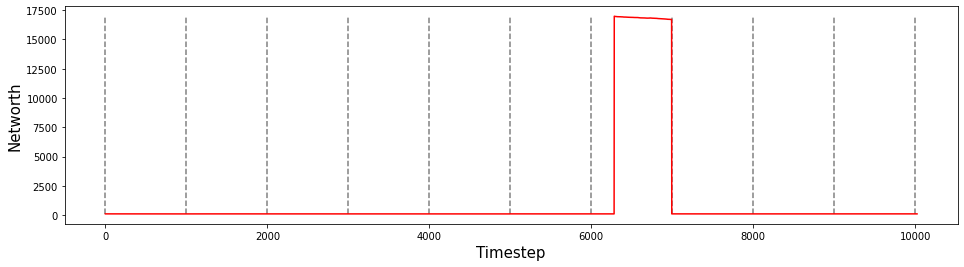

In [ ]:
# Train the model
rainbow_agent.train_model()

# The End!